In [1]:
# coding: utf-8

import numpy as np
import pandas as pd
from bandits_weights_update import BetaBandits, GammaBandits
from numpy.random import normal,multivariate_normal, gamma
from numpy.linalg import inv, pinv, matrix_rank
import scipy.stats as stats
import json
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import starmap
import multiprocessing


## fitting phase
def linreg_conjugate_prior(design_mat,
                           obs_mat,
                           prior=None):
    
    num_data, design_vars = design_mat.shape

    if prior is None:
        prior = {'mean': np.zeros(design_vars),
                 'precision': 10 * np.eye(design_vars),
                 'shape': 10,
                 'scale': 1
                }
    
    normal_mat = design_mat.T @ design_mat
    lsq_coef = pinv(normal_mat) @ (design_mat.T @ obs_mat)
    dof = num_data - matrix_rank(design_mat)
    obs_diff = obs_mat - (design_mat @ lsq_coef)
    deviance = 1/dof*(obs_diff.T @ obs_diff)
    
    upd_prior = dict()
    upd_prior['precision'] = prior['precision'] + normal_mat
    upd_prior['mean'] = (pinv(upd_prior['precision']) @ ((prior['precision'] @ prior['mean']) +
                                                        (normal_mat @ lsq_coef)))
    alpha = 2*prior['shape']
    beta = 2/(prior['scale']*alpha)
    
    upd_alpha = alpha + num_data
    upd_beta = (1/upd_alpha)*(alpha*beta + prior['mean'].T @ prior['precision'] @ prior['mean'] +
                            dof*deviance + lsq_coef.T @ normal_mat @ lsq_coef - 
                            upd_prior['mean'].T @ upd_prior['precision'] @ upd_prior['mean'] )

    upd_prior['shape'] = upd_alpha/2
    upd_prior['scale'] = 2/(upd_alpha*upd_beta)

    return upd_prior
    

In [2]:
def generateContinuousDesignMat(nobs_total, variants_list, test_split):
    n_variant = int(test_split*nobs_total/len(variants_list))
    n_control = int(nobs_total - (n_variant*len(variants_list)))
    variants_col = np.concatenate((np.zeros(n_control),np.repeat(np.array(variants_list),n_variant)))
    design_mat = np.stack((np.ones(int(nobs_total)),variants_col),axis=-1)
    return design_mat

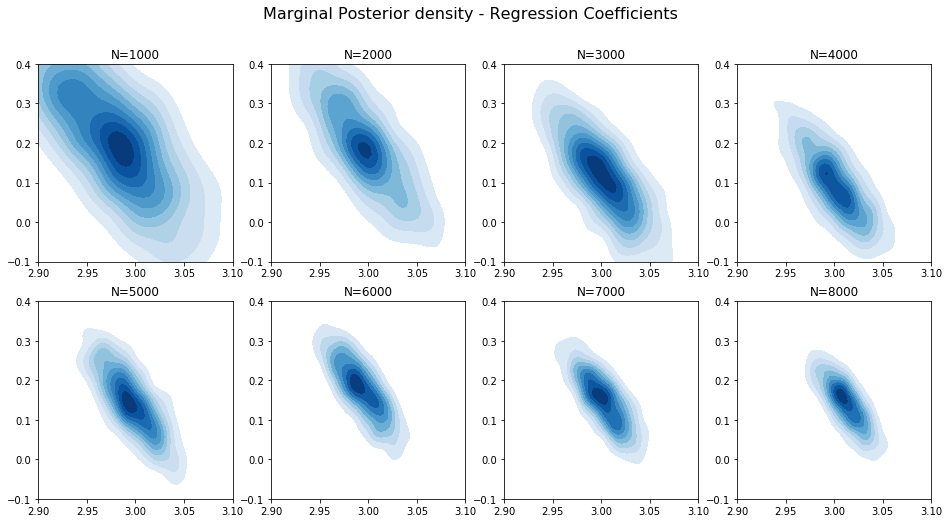

In [9]:
num_data = 1000
true_coef = {'mean': np.array([3,0.2]),'cov': np.array([[1, 0],[0, 1]]) }
init_prior = {'mean': np.array([0,0]),
                                'precision': np.array([[10,0],[0,10]]),
                                'shape': 10,
                                'scale': 1}

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

for i, ax in enumerate(axs.reshape(-1)):
    design_mat = generateContinuousDesignMat(num_data,[0.1,0.2,0.3,0.4,0.5],0.8)

    
    coef_draw = multivariate_normal(mean=true_coef['mean'], cov=true_coef['cov'],size=num_data)
    obs_mat = np.sum(design_mat * coef_draw, axis = 1)
    
    upd_prior = linreg_conjugate_prior(design_mat,obs_mat,
                           prior = init_prior)
    init_prior = upd_prior
    draws = np.array([multivariate_normal(init_prior['mean'],inv((gamma(init_prior['shape'], init_prior['scale'])*init_prior['precision']))) for a in range(1000)])
    sns.kdeplot(draws[:,0],draws[:,1], ax=ax, cmap="Blues", shade=True, shade_lowest=False, )
    ax.set_title('N=%d'%((i+1)*num_data))
    ax.set(xlim=(2.9, 3.1))
    ax.set(ylim=(-0.1, 0.4))
    

## Linear models for contextual bandits (sort of)
### Using the conjugate prior linear regression

In [4]:
from patsy import dmatrix, demo_data

num_data = 100

orig_data = demo_data("a","x",nlevels=3,min_rows=num_data)


design_mat_patsy = dmatrix("a + x", orig_data)

design_mat_arr = np.asarray(design_mat_patsy)

## setting the matrix to be singular
design_mat_arr[:,2] = 0

num_data_patsy, num_var_patsy = np.asarray(design_mat_arr).shape

true_coef_patsy = {'mean': normal(size=num_var_patsy),'cov': np.diag(np.ones(num_var_patsy))}
coef_draw_patsy = multivariate_normal(mean=true_coef_patsy['mean'], cov=true_coef_patsy['cov'],size=num_data_patsy)

obs_patsy = np.sum(design_mat_arr * coef_draw_patsy, axis = 1)

upd_prior_patsy = linreg_conjugate_prior(design_mat_arr,obs_patsy)

draws_coef_patsy = np.array([multivariate_normal(upd_prior_patsy['mean'],inv((gamma(upd_prior_patsy['shape'], upd_prior_patsy['scale'])*upd_prior_patsy['precision']))) for a in range(1000)])

In [5]:
linreg_samples = pd.DataFrame(draws_coef_patsy,columns=design_mat_patsy.design_info.column_names).describe(percentiles=[.025, 0.25, 0.5, 0.75, 0.975]).transpose()
linreg_samples

,count,mean,std,min,2.5%,25%,50%,75%,97.5%,max
Intercept,1000.0,1.078362,0.157810,0.484419,0.764133,0.974812,1.081820,1.188230,1.392343,1.575231
a[T.a2],1000.0,0.074419,0.261813,-0.959926,-0.416012,-0.086351,0.069581,0.253475,0.573259,0.927939
a[T.a3],1000.0,-0.009152,0.472347,-1.531046,-0.926827,-0.329189,0.004215,0.326056,0.903426,1.815283
x,1000.0,-0.248217,0.137660,-0.712153,-0.510669,-0.341521,-0.253953,-0.157777,0.025335,0.227414


In [6]:
upd_prior_patsy

{'precision': array([[112.        ,  34.        ,   0.        ,   6.51619319],
        [ 34.        ,  44.        ,   0.        ,   9.41635112],
        [  0.        ,   0.        ,  10.        ,   0.        ],
        [  6.51619319,   9.41635112,   0.        , 117.30307283]]),
 'mean': array([ 1.08243669,  0.07062022,  0.        , -0.24149177]),
 'shape': 61.0,
 'scale': 0.007834610193699196}

In [7]:
true_coef_patsy

{'mean': array([ 1.25530972, -0.00595983, -0.99427038, -0.34791027]),
 'cov': array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])}

### using the SGDRegression

In [8]:
from sklearn.linear_model import SGDRegressor

# Create an SGDClassifier instance which will have methods to do our linear regression fitting by gradient descent
fitter = SGDRegressor(loss="squared_loss", penalty=None,fit_intercept=False)



fitter.fit(design_mat_arr, obs_patsy)
fitter.__dict__

{'loss': 'squared_loss',
 'penalty': None,
 'learning_rate': 'invscaling',
 'epsilon': 0.1,
 'alpha': 0.0001,
 'C': 1.0,
 'l1_ratio': 0.15,
 'fit_intercept': False,
 'shuffle': True,
 'random_state': None,
 'verbose': 0,
 'eta0': 0.01,
 'power_t': 0.25,
 'early_stopping': False,
 'validation_fraction': 0.1,
 'n_iter_no_change': 5,
 'warm_start': False,
 'average': False,
 'max_iter': 1000,
 'tol': 0.001,
 'coef_': array([ 1.12973918,  0.16795497,  0.        , -0.26817274]),
 'intercept_': array([0.]),
 't_': 2041.0,
 'n_iter_': 20}